# Assignment 2
DDQN Algorithm on Grid & Cart Pole environment

**Author:** @sivashanmugamo

## Prerequisites

*Importing required libraries*

In [862]:
import os, math, time, random, pickle
from itertools import count
from collections import deque, OrderedDict, namedtuple
from copy import deepcopy

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import torchvision
from torchvision import transforms as T

*Checking GPU availability*

In [863]:
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

*Initializing the positions of the agent, goal, and rewards*

In [864]:
AGENT_POS= [0, 0]
DIAMOND_POS= [1, 3]
COIN_POS= [3, 2]
MONSTER_POS= [2, 1]
GOAL_POS= [3, 3]

*Pre-defining the minimum number of states and actions that will be used in the environment*

In [865]:
N_STATES= 16
N_ACTIONS= 4
MAX_TIMESTEPS= 200

*Initializing lookup dictionaries for states & actions*

In [866]:
STATE_LOOKUP= dict()
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

k= 0
for i in range(4):
  for j in range(4):
    STATE_LOOKUP[(i, j)]= k
    k+= 1

*Defining a simple 4x4 deterministic environment*

In [867]:
class Environment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self) -> None:
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self) -> int:
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]

  def step(self, action: int) -> tuple:
    '''
    1. Moves the agent as per the given action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return (STATE_LOOKUP[tuple(agent_state)], reward, done, info)

  def render(self) -> None:
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

*Test render*

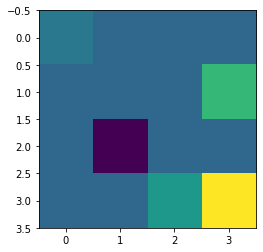

In [868]:
env_1= Environment()

env_1.reset()
env_1.render()

In [869]:
env_2= gym.make('CartPole-v1')

## DDQN

### Experience Replay

In [870]:
experience= namedtuple('experience', ['state', 'action', 'next_state', 'reward', 'done'])

class Memory:
    def __init__(self, capacity) -> None:
        '''
        Creates a memory buffer for the agent

        Input:
            capacity: int - Maximum memory size
        '''
        
        self.capacity= capacity
        self.memory= deque(maxlen= self.capacity)

    def memorize(self, observation: tuple) -> None:
        '''
        Memorizes an experience to the memory (i.e.) adds an observation to the memory buffer

        Input:
            observation: tuple - Contains agent's current state, action performed, agent's next state, 
            reward achieved, and done status
        '''

        self.memory.append(experience(*observation))

    def sample(self, batch_size) -> tuple:
        '''
        Samples a random batch of experiences from the memory

        Input:
            batch_size: int - Number of experiences needed to train the model
        Returns:
            tuple - Set of states, actions, next_states, rewards, and dones
        '''

        experiences= random.sample(self.memory, batch_size)

        states= [i.state for i in experiences]
        actions= [i.action for i in experiences]
        next_states= [i.next_state for i in experiences]
        rewards= [i.reward for i in experiences]
        dones= [i.done for i in experiences]

        return (states, actions, next_states, rewards, dones)

    def __len__(self):
        '''
        Returns the size of the filled memory
        '''

        return len(self.memory)

### Q-Network

In [871]:
class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, conv_net: bool= False, n_hidden: int= 1, hidden_width: int= 128) -> None:
        '''
        Builds a NN for the required specifications

        Input:
            input_dim: tuple of int - Dimension of the input data
            output_dim: int - Number of Q-values to be determined (i.e.) Q-value for each action
            conv_net: bool - If the environment requires CNN or not
            n_hidden: int - Number of hidden layers
            hidden_width: int - Number of nodes in each hidden layer
        '''

        super(DQN, self).__init__()
        
        self.input_dim= input_dim
        self.n_hidden= n_hidden
        self.hidden_layers= list()
        self.hidden_width= hidden_width
        self.output_dim=output_dim
        self.conv_net= conv_net

        self.device= DEVICE

        if self.conv_net:
            self.build_cnn()
        else:
            self.build_nn()

    def build_nn(self) -> None:
        '''
        Builds a NN for the given specifications
        '''

        for each_layer in range(self.n_hidden):
            self.hidden_layers.append(nn.Linear(self.hidden_width, self.hidden_width))
            self.hidden_layers.append(nn.ReLU())

        self.model= nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_width), 
            nn.ReLU(), 
            *self.hidden_layers, 
            nn.Linear(self.hidden_width, self.output_dim)
        )

        if self.device == 'cuda':
            self.model.cuda()

    def build_cnn(self) -> None:
        '''
        Builds a CNN for the given specifications
        '''

        # Convolutional Neural Network (CNN) layers
        self.cnn= nn.Sequential(
            nn.Conv2d(self.input_dim, 32, kernel_size= 8, stride= 4), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size= 4, stride= 2), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride= 1), 
            nn.ReLU()
        )

        # Building fully connected hidden layers
        for each_layer in range(self.n_hidden):
            self.hidden_layers.append(nn.Linear(self.hidden_width, self.hidden_width))
            self.hidden_layers.append(nn.ReLU())

        # Calculating fully connected layer input dimension
        self.cnn_out_dim= self.cal_cnn_out()

        # Fully Connected Network (FCN) layers
        self.fcn= nn.Sequential(
            nn.Linear(self.cnn_out_dim, self.hidden_width), 
            nn.ReLU(), 
            *self.hidden_layers, 
            nn.Linear(self.hidden_width, self.output_dim)
        )

        # If GPU available, move model to GPU for faster processing
        if self.device == 'cuda':
            self.cnn.cuda()
            self.fcn.cuda()

    def cal_cnn_out(self):
        '''
        Output size of the CNN model can be using the following formula,
        size= ((w - k + 2p) / s)+1 where, w (width) is the input dimension; k is the kernel size;
        p is the padding size; and s is the stride value.

        But another alternative method is to propagate an empty tensor through the CNN and find the
        output size from the model's output.

        Input:
            input_dim: tuple of int - Dimension of the input data Eg: (1, 4 [frame stack], 
            84 [frame height], 84 [frame width])
        Returns:
            int - Number of outputs for the built CNN model
        '''
        return self.cnn(torch.zeros(*self.input_dim)).flatten().shape[0]

    def predict(self, tensor_input: torch.tensor):
        '''
        Predicts the Q-values for the action space based on given state
        '''
        if self.conv_net:
            # CNN Prediction
            cnn_pred= self.cnn(tensor_input)
            return self.fcn(cnn_pred.view(cnn_pred.size(0), -1))
        else:
            # NN Prediction
            return self.model(tensor_input)

### Agent

In [872]:
class DQNAgent:
    def __init__(self, env, conv_net: bool, env_name: str, learning_rate: float= 0.001, discount_factor: float= 0.999, tau: float= 0.01, memory_size: int= 10000) -> None:
        '''
        Double Deep Q-Learning Agent

        Input:
            env: Instance of the environement
            conv_net: bool - If the environment requires CNN or not
            env_name: str - Name of the environement
            learning_rate: float - Rate at which the agent learns
            discount_factor: float - Discount factor
            tau: float - Weight update factor
            memory_size: int - Agent's memory capacity
        '''
        
        self.env= env
        
        if env_name == 'grid':
            self.state_space= N_STATES
            self.action_space= N_ACTIONS
        else:
            self.state_space= env.observation_space.shape[0]
            self.action_space= env.action_space.n

        self.alpha= learning_rate
        self.gamma= discount_factor
        self.tau= tau

        self.device= DEVICE
        self.conv_net= conv_net

        # Initialize replay memory D to capacity N
        self.memory= Memory(capacity= memory_size)

        # Initialize action-value function Q with random weights theta
        self.agent_model= DQN(
            input_dim= self.state_space, 
            output_dim= self.action_space, 
            conv_net= self.conv_net
        )

        # Initialize target action-value function Q^ with weights (theta)^ = theta
        self.target_model = deepcopy(self.agent_model)

        #  Initializing an optimmizer for the model
        self.optimizer= optim.Adam(self.agent_model.parameters())

        # Initialize loss function
        self.loss_func= nn.MSELoss()

    def action(self, state, eps= 0.2):
        '''
        Chooses what action to take based on epsilon value
        '''
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        Q_pred = self.agent_model.predict(state)
        action = np.argmax(Q_pred.cpu().detach().numpy())
        
        if(np.random.randn() < eps):
            return self.env.action_space.sample()

        return action

    def cal_loss(self, batch):
        states, actions, rewards, next_states, dones = batch

        state_t= torch.FloatTensor(states).to(self.device)
        action_t= torch.LongTensor(actions).to(self.device)
        reward_t= torch.FloatTensor(rewards).to(self.device)
        next_state_t= torch.FloatTensor(next_states).to(self.device)
        done_t= torch.FloatTensor(dones)

        action_t= action_t.view(action_t.size(0), 1)
        done_t= done_t.view(done_t.size(0), 1)

        pred_Q= self.agent_model.predict(state_t).gather(1, action_t)
        next_Q_pred= self.target_model.predict(next_state_t)
        next_Q_max= torch.max(next_Q_pred, 1)[0]
        next_Q_max= next_Q_max.view(next_Q_max.size(0), 1)
        expected_Q= reward_t + (1 - done_t) * self.gamma * next_Q_max
        
        return F.mse_loss(pred_Q, expected_Q.detach())

    def learn(self, batch_size: int):
        # Sampling
        sample= self.memory.sample(batch_size)
        
        # Model optimization
        loss= self.cal_loss(sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        for target_w, agent_w in zip(self.target_model.parameters(), self.agent_model.parameters()):
            target_w.data.copy_(self.tau * agent_w + (1 - self.tau) * target_w)

## Execute

In [873]:
def run(env, env_name, agent, n_episodes: int= 1000, max_timestep: int= 500, batch_size: int= 64):
    reward_list= list()

    for each_episode in range(n_episodes):
        if env_name == 'grid':
            state= [1 if i == env.reset() else 0 for i in range(0, N_STATES)]
        else:
            state= env.reset()
        reward_per_episode = 0

        for each_timestep in range(max_timestep):
            action= agent.action(state)
            if env_name == 'grid':
                next_state, reward, done, info= env.step(action)
                next_state= deepcopy([1 if i == next_state else 0 for i in range(0, N_STATES)])
            else:
                next_state, reward, done, info= env.step(action)
            agent.memory.memorize((state, action, reward, next_state, done))
            reward_per_episode += reward
            state= next_state

            if len(agent.memory) > batch_size:
                agent.learn(batch_size)

            if done or each_timestep == max_timestep-1:
                reward_list.append(reward_per_episode)
                if each_episode % 100 == 0:
                    print("Episode: {} | Average reward: {}".format(each_episode, sum(reward_list)/len(reward_list)))
                break

    return reward_list

### Cart Pole Environment

In [874]:
env_2.reset()
agent_2= DQNAgent(env= env_2, env_name= '', conv_net= False)
rewards_2= run(env= env_2, env_name= '', agent= agent_2, n_episodes= 500)

Episode: 0 | Episode's reward: 20.0
ipykernel_launcher:82: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Episode: 100 | Episode's reward: 58.415841584158414
Episode: 200 | Episode's reward: 57.49751243781095
Episode: 300 | Episode's reward: 54.435215946843854
Episode: 400 | Episode's reward: 52.72069825436409


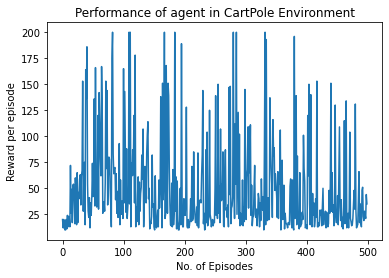

In [883]:
fig= plt.figure()
plt.plot(np.arange(len(rewards_2)), rewards_2)
plt.title('Performance of agent in CartPole Environment')
plt.xlabel('No. of Episodes')
plt.ylabel('Reward per episode')
plt.show()

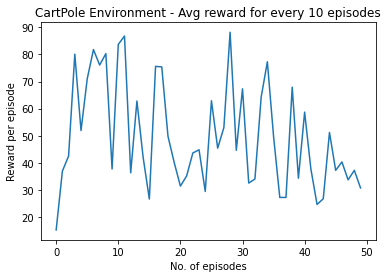

In [884]:
fig= plt.figure()
plt.plot(np.arange(len(rewards_2)/10), [sum(rewards_2[n:n+10])/10 for n in range(0, len(rewards_2), 10)])
plt.title('CartPole Environment - Avg reward for every 10 episodes')
plt.xlabel('No. of episodes')
plt.ylabel('Reward per episode')
plt.show()

### Grid Environment

In [876]:
env_1.reset()
agent_1= DQNAgent(env= env_1, env_name= 'grid', conv_net= False)
rewards_1= run(env= env_1, env_name= 'grid', agent= agent_1, n_episodes= 500)

Episode: 0 | Episode's reward: 15.0
ipykernel_launcher:82: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
Episode: 100 | Episode's reward: 46.663366336633665
Episode: 200 | Episode's reward: 37.850746268656714
Episode: 300 | Episode's reward: 39.42192691029901
Episode: 400 | Episode's reward: 41.49625935162095


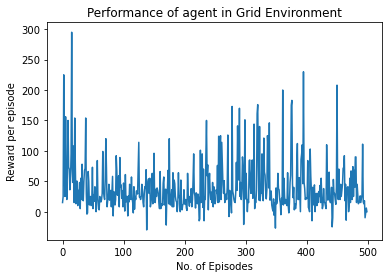

In [885]:
fig_1= plt.figure()
plt.plot(np.arange(len(rewards_1)), rewards_1)
plt.title('Performance of agent in Grid Environment')
plt.xlabel('No. of Episodes')
plt.ylabel('Reward per episode')
plt.show()

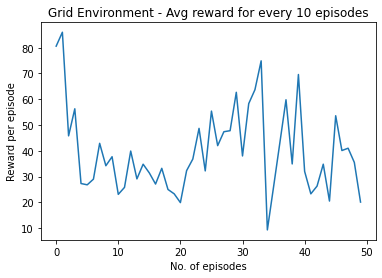

In [886]:
fig= plt.figure()
plt.plot(np.arange(len(rewards_1)/10), [sum(rewards_1[n:n+10])/10 for n in range(0, len(rewards_1), 10)])
plt.title('Grid Environment - Avg reward for every 10 episodes')
plt.xlabel('No. of episodes')
plt.ylabel('Reward per episode')
plt.show()